# Simulation Description
We would like to answer if the nonlinear local dynamics for the contact process has a stationary distribution, in particular a distribution that solves its associated nonlinear Markov chain. If $\pi \in \mathcal{P}([0,1]^3)$ denotes the distribution of the process at some time, then we want to understand the fixed point equation
$$
\pi = \pi Q^\pi,
$$
where $Q$ is the transition kernel of the nonlinear Markov chain with dependence on $\pi.$ To understand this, we would like to iterate the equation above as in $\pi_{k+1} = \pi_k Q^{\pi_k}$ and see if some form of convergence holds.

Of course, we understand that simulating this nonlinear Markov chain is infeasible since we require keeping track of the infinite history, as well as computing a conditional expectation. So we consider first the order $k$ Markov approximation, which requires that we only consider the past k states; this allows us to discretize our space $[0,1]^3$ into dyadic partitions and consider measures which are constant on these partitions. In this way we are able to compute conditional expectations nearly explicitly.

The issue with transitioning with our nonlinear kernel starting from a measure constant on partitions $D_k,$ is that we obtain a measure that is constant on partitions $D_{k+1}.$ Simulating this measure would require us to keep track of exponentially many values, so what we do instead is to consider the transition kernel mapping to $D_{k+1},$ and then back to $D_k$ by averaging. This is the k order Markov approximation, so long as conditioning on a finite past is equivalent to conditioning on a finite past in the conditional expectation that appears in the transition kernel below. We look for stationary distributions of these dynamics. 

## Nonlinear Markov approximation

# Defining Measures 
We want to work with measures that are constant on dyadic intervals.

In [1]:
import numpy as np
import itertools as itr
def create_k_measure(vector,k):
    
    side = 2**k
    # use numpy array to model this measure
    measure = np.array(vector).reshape((side,side,side))
    
    # have to normalize this measure
    return measure/measure.sum()
    
    
def create_random_k_measure(k):
    return create_k_measure(np.random.uniform(0,1,2**(3*k)),k)

def smoothen(measure,k):
    side_length = measure.shape[0]
    assert side_length >= 2**k
    
    if side_length == 2**k:
        return measure
    
    smoothed_measure = np.zeros(shape = (2**k,2**k,2**k))
    smoothed_idxs = np.arange(0,2**k)
    smoothed_length = int(side_length/(2**k))
    for i,j,k in itr.product(smoothed_idxs,smoothed_idxs,smoothed_idxs):
        smoothed_measure[i,j,k] = measure[(smoothed_length*i):(smoothed_length*(i+1)),
                                          (smoothed_length*j):(smoothed_length*(j+1)),
                                          (smoothed_length*k):(smoothed_length*(k+1))].sum()
        
    
    return smoothed_measure

# Defining the dynamics

$\newcommand{\Prob}{\mathbb{P}}
\DeclareMathOperator{\Law}{Law}
\DeclareMathOperator{\Ber}{Bernoulli}
\newcommand{\set}[1]{\lbrace #1\rbrace}
\newcommand{\ceil}[1]{\left\lceil #1 \right\rceil}
\newcommand{\floor}[1]{\left\lfloor #1 \right\rfloor}
\newcommand{\E}{\mathbb{E}}$

Recall that we can define our dynamics to be as follows:

For $\mathbf{x} = (\mathbf{x}_{-1},\mathbf{x}_0,\mathbf{x}_1) \in [0,1]^3$ we can write the transition kernel of the nonlinear Markov process as
$$
\Prob^\mu(\mathbf{x},\cdot) = \operatorname{Law}(\frac{1}{2}\mathbf{x} + \frac{1}{2}\mathbf{v}(\mathbf{x},\mu)),
$$
where 
$$
\mathbf{v}(\mathbf{x},\mu) \sim \Ber(F_{(-1)}(\mu,\mathbf{x})) \otimes \Ber(F_{(0)}(\mu,\mathbf{x})) \otimes \Ber(F_{(1)}(\mu,\mathbf{x}))
$$
is a product measure, with the functionals $F_v(\mu,\mathbf{x}), v\in V$ defined as follows:
\begin{align*}
    F_{(0)}(\mu,\mathbf{x}) & = \frac{p}{2} (\floor{2\mathbf{x}_{-1}} + \floor{2\mathbf{x}_{1}})\mathbf{1}_{\set{\floor{2\mathbf{x}_0} = 0}} + (1-q)\mathbf{1}_{\set{\floor{2\mathbf{x}_0} = 1}} \\
    F_{(1)}(\mu,\mathbf{x}) & = \frac{p}{2} (\floor{2\mathbf{x}_{0}} + \E^{\mathbf{y} \sim \mu}[ \ \floor{2\mathbf{y}_1} \ | \ \mathbf{y}_0 = \mathbf{x}_1, \mathbf{y}_{-1} = \mathbf{x}_0])\mathbf{1}_{\set{\floor{2\mathbf{x}_1} = 0}} + (1-q)\mathbf{1}_{\set{\floor{2\mathbf{x}_1} = 1}} \\
    F_{(-1)}(\mu,\mathbf{x}) & = \frac{p}{2} (\floor{2\mathbf{x}_{0}} + \E^{\mathbf{y} \sim \mu}[ \ \floor{2\mathbf{y}_{-1}} \ | \ \mathbf{y}_0 = \mathbf{x}_{-1}, \mathbf{y}_1 = \mathbf{x}_0])\mathbf{1}_{\set{\floor{2\mathbf{x}_{-1}} = 0}} + (1-q)\mathbf{1}_{\set{\floor{2\mathbf{x}_{-1}} = 1}} 
\end{align*}

The difficult part of simulating these dynamics in the general case is to compute the conditional expectation, whereupon we fix the values of two of the coordinates, and compute a functional of the third coordinate with respect to this conditioning. This is made easier in the order $k$ Markov approximation case, since we are conditioning with respect to unions of cubes in the dyadic partition rather than lines of measure zero, which would have been the case in the original dynamics.

In [2]:
# We can define the current state with respect to the measure itself, by specifying the indices.
def compute_conditional_expectation(measure, case, current_state):
    side_length = measure.shape[0]
    expectation = 0
    if case == 1:
        conditioned_measure = measure[current_state[1],current_state[2],:]
        if conditioned_measure.sum() != 0:
            conditioned_measure = conditioned_measure/conditioned_measure.sum()
        expectation = sum([prob for idx,prob in enumerate(conditioned_measure) if idx >= side_length/2])
        
    elif case == -1:
        conditioned_measure = measure[:,current_state[0],current_state[1]]
        if conditioned_measure.sum() != 0:
            conditioned_measure = conditioned_measure/conditioned_measure.sum()
        expectation = sum([prob for idx,prob in enumerate(conditioned_measure) if idx >= side_length/2])
        
    else: 
        print('case should be either 1,-1.')
        
    return expectation
    
# computes the functionals above.  
def compute_functionals(measure, coordinate, current_state,p,q):
    side_length = measure.shape[0]
    midpoint_idx = int(side_length/2)
    functional = 0
    
    if coordinate == 0:
        functional = (p/2)*int(current_state[1] < midpoint_idx)* \
            ((current_state[2] >= midpoint_idx) + (current_state[0] >= midpoint_idx)) + \
            int(current_state[1] >= midpoint_idx)*(1-q)
            
    elif coordinate == -1:
        functional = (p/2)*int(current_state[0] < midpoint_idx)* \
            ((current_state[1] >= midpoint_idx) + compute_conditional_expectation(measure,-1,current_state)) + \
            int(current_state[0] >= midpoint_idx)*(1-q)
            
    elif coordinate == 1:
        functional = (p/2)*int(current_state[2] < midpoint_idx)* \
            ((current_state[1] >= midpoint_idx) + compute_conditional_expectation(measure,1,current_state)) + \
            int(current_state[2] >= midpoint_idx)*(1-q)
    else:
        print("coordinate should be one of -1,0,1")
        
    return functional

# computes transition probability 
# transition map is a 3-tuple in {0,1}^3, which describes how to transition to the next state
# it is the vector v above
def compute_transition_probability(measure, current_state, transition_map, p,q):
    
    probs = [0]*3
    for i in range(3):
        probs[i] = compute_functionals(measure, i-1, current_state, p, q)
    
    probs = np.array(probs)
    m = np.array([1-probs,probs])
    
    return np.product(m[transition_map,range(3)])

# returns another measure, of the same discretization
def transition(measure,p,q):
    side_length = measure.shape[0]
    new_side_length = 2*side_length
    new_measure = np.zeros([new_side_length]*3)
    
    # transition for each element in the old measure
    for i,j,k in itr.product(range(side_length),range(side_length),range(side_length)):
        for transition in list(itr.product([0,1],[0,1],[0,1])):
            
            transition_prob = compute_transition_probability(measure, [i,j,k], transition, p,q)
            new_coordinates = np.array([i,j,k]) + side_length*np.array(transition)
            new_measure[tuple(new_coordinates)] = \
                new_measure[tuple(new_coordinates)] + \
                measure[i,j,k]*transition_prob 
    
    return smoothen(new_measure, int(np.log2(side_length)))

# Investigate Convergence Properties:
We iterate this process, and analyze convergence. We can only really consider up to $k=4$, in which case we need to keep track of $(2^4)^3$ items, which takes quite a while to simulate.

This is a nonlinear Markov process; we should check the conditions for unique ergodicity in this case

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def simulate_nonlinear_dynamics(initial_measure,p,q):
    mu_0 = initial_measure
    mu_current = mu_0

    consec_diff = []
    while True:
        mu_next = transition(mu_current,p,q)
        consec_diff = consec_diff + [np.sqrt(((mu_next - mu_current)**2).sum())] 
        mu_current = mu_next
        if consec_diff[-1] < 1e-10:
            break

    return (consec_diff, mu_current)

def simulate_nonlinear_dynamics_for_fixed_steps(initial_measure,p,q,steps):
    mu_0 = initial_measure
    mu_current = mu_0

    consec_diff = []
    for i in range(steps):
        mu_next = transition(mu_current,p,q)
        consec_diff = consec_diff + [np.sqrt(((mu_next - mu_current)**2).sum())] 
        mu_current = mu_next

    return (consec_diff, mu_current)

def l2norm(x,y):
    return np.sqrt(((x-y)**2).sum())

## Convergence as a function of k
We count the average number of iterations it takes for the consecutive $\mathbb{L}^2$ differences of the measures, viewed as vectors, to be less than $10^{-10}.$ We average this over multiple initializations of the starting measure.

In [683]:
num_measures = 5
p = 0.5; q = 0.5
K = 5

Simulation_lengths = pd.DataFrame(index = range(1,1+num_measures) , columns = range(1,K+1) )
for i in range(num_measures):
    for k in range(K):
        results = simulate_nonlinear_dynamics(create_random_k_measure(k),p,q)
        Simulation_lengths.iloc[i,k] = len(results[0]) 

In [684]:
Simulation_lengths.columns = list("12345")
lengths = Simulation_lengths.melt().astype(np.float)
print(Simulation_lengths.mean())
print(Simulation_lengths.std())

1     1.0
2    94.6
3    94.4
4    95.0
5    96.2
dtype: float64
1    0.000000
2    0.547723
3    0.547723
4    0.000000
5    0.447214
dtype: float64


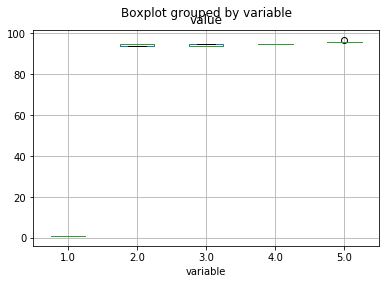

In [685]:
boxplot = lengths.boxplot(column = 'value', by = 'variable')
plt.show()

## Do marginals of measures agree?

In [686]:
p = 0.5; q= 0.5
K = 5
fixedpoints = [0]*K
for k in range(1,K+1):
    fixedpoints[k-1] = simulate_nonlinear_dynamics(create_random_k_measure(k),p,q)[1]

In [687]:
for k in range(K):
    print("Distance between %s stationary measure and marginal of the %s stationary measure: %f "%(k,K, \
          l2norm(fixedpoints[k],smoothen(fixedpoints[4],k+1))))

Distance between 0 stationary measure and marginal of the 5 stationary measure: 0.000000 
Distance between 1 stationary measure and marginal of the 5 stationary measure: 0.000000 
Distance between 2 stationary measure and marginal of the 5 stationary measure: 0.000000 
Distance between 3 stationary measure and marginal of the 5 stationary measure: 0.000000 
Distance between 4 stationary measure and marginal of the 5 stationary measure: 0.000000 


In [688]:
print(fixedpoints[0])

[[[  9.99999958e-01   1.10253884e-08]
  [  8.20067081e-09   4.44613447e-09]]

 [[  1.10253884e-08   1.62141685e-09]
  [  4.44613447e-09   1.62141682e-09]]]


## Investigate convergence as a function of the parameters
Characterize time it takes to converge as a function of the parameters

In [691]:
values = np.zeros((10,10))
for i,j in itr.product(np.arange(10),np.arange(10)):
    p = i/10; q = j/10
    values[i,j] = len(simulate_nonlinear_dynamics(create_random_k_measure(2),p,q)[0])

In [692]:
print(values)

[[  2.00000000e+00   1.60000000e+02   8.00000000e+01   5.20000000e+01
    3.80000000e+01   2.90000000e+01   2.20000000e+01   1.80000000e+01
    1.40000000e+01   1.10000000e+01]
 [  3.12000000e+02   3.77000000e+02   1.24000000e+02   7.10000000e+01
    4.90000000e+01   3.60000000e+01   2.80000000e+01   2.20000000e+01
    1.70000000e+01   1.40000000e+01]
 [  1.56000000e+02   1.67000000e+03   2.00000000e+02   9.80000000e+01
    6.30000000e+01   4.50000000e+01   3.40000000e+01   2.60000000e+01
    2.10000000e+01   1.70000000e+01]
 [  1.01000000e+02   5.90000000e+02   3.72000000e+02   1.40000000e+02
    8.20000000e+01   5.60000000e+01   4.10000000e+01   3.20000000e+01
    2.60000000e+01   2.10000000e+01]
 [  7.40000000e+01   1.85000000e+02   1.22500000e+03   2.17000000e+02
    1.10000000e+02   7.10000000e+01   5.10000000e+01   3.90000000e+01
    3.10000000e+01   2.60000000e+01]
 [  6.00000000e+01   1.14000000e+02   7.71000000e+02   4.06000000e+02
    1.59000000e+02   9.50000000e+01   6.50000

## Check dependence on initial measure
There seems to be a unique stationary distribution, other than 0.

In [689]:
l2norms = [0]*50
stat_measures = [0]*50
for i in range(50):
    stat_measures[i] = simulate_nonlinear_dynamics(create_random_k_measure(3),0.5,0.5)[1]
    l2norms[i] = np.sqrt((stat_measures[i]**2).sum())

In [690]:
print(max(l2norms),min(l2norms))

0.999999958275 0.999999950361


### Is zero a fixed point?
Yes it is. 

In [670]:
k = 2
measure = np.zeros(shape = (2**k,2**k,2**k))
# Perturb the zero measure:
measure[0,0,0] = 1

In [673]:
measure = transition(measure,0.5,0.5)
measure

array([[[ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

### Investigate the high infection rate case:
It has a different stationary measure than the zero mass!

In [23]:
p = 0.95; q= 0.05
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[  3.52892275e-04,   3.57189403e-03],
        [  2.61758336e-03,   4.71861773e-02]],

       [[  3.57189403e-03,   4.62318667e-02],
        [  4.71861773e-02,   8.49281515e-01]]])

### How does the ratio of p/q affect the stationary distribution?

In [25]:
p = 0.98; q= 0.02
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[  1.95240302e-05,   5.48724210e-04],
        [  4.07840474e-04,   1.95807946e-02]],

       [[  5.48724210e-04,   1.94399108e-02],
        [  1.95807946e-02,   9.39873687e-01]]])

In [36]:
ratio = 20
p = ratio/(1+ratio); q= 1/(1+ratio)
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[  3.01265372e-04,   3.22970969e-03],
        [  2.36953606e-03,   4.50813699e-02]],

       [[  3.22970969e-03,   4.42211963e-02],
        [  4.50813699e-02,   8.56485843e-01]]])

In [32]:
ratio = 5
p = ratio/(1+ratio); q= 1/(1+ratio)
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[ 0.02492492,  0.04432234],
        [ 0.03052379,  0.12460167]],

       [[ 0.04432234,  0.11080312],
        [ 0.12460167,  0.49590016]]])

In [33]:
ratio = 2
p = ratio/(1+ratio); q= 1/(1+ratio)
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[ 0.82569618,  0.03514778],
        [ 0.02153145,  0.0248539 ]],

       [[ 0.03514778,  0.01123757],
        [ 0.0248539 ,  0.02153145]]])

In [37]:
ratio = 1.75
p = ratio/(1+ratio); q= 1/(1+ratio)
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[  9.99999995e-01,   1.11241999e-09],
        [  7.00299535e-10,   6.85498107e-10]],

       [[  1.11241999e-09,   2.73377656e-10],
        [  6.85498107e-10,   4.78410898e-10]]])

In [34]:
ratio = 1.5
p = ratio/(1+ratio); q= 1/(1+ratio)
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[  9.99999998e-01,   3.83376086e-10],
        [  2.54278827e-10,   2.11471843e-10]],

       [[  3.83376086e-10,   8.23745845e-11],
        [  2.11471843e-10,   1.23561877e-10]]])

In [35]:
ratio = 1
p = ratio/(1+ratio); q= 1/(1+ratio)
simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1]

array([[[  1.00000000e+00,   1.07535698e-10],
        [  7.99849244e-11,   4.33651996e-11]],

       [[  1.07535698e-10,   1.58144255e-11],
        [  4.33651996e-11,   1.58144255e-11]]])

In [53]:
# Is there a phase change in the ratio?
def norm(matrix):
    return np.sqrt(np.sum(matrix**2))


differences_from_zero_mass = np.zeros((1,50))
ratios = np.linspace(1,2,50)
zero_mass = np.zeros((2,2,2)); zero_mass[0,0,0] = 1
for i in range(len(ratios)):
    p = ratios[i]/(1+ratios[i]); q= 1/(1+ratios[i])
    differences_from_zero_mass[0,i] = norm(simulate_nonlinear_dynamics(create_random_k_measure(1),p,q)[1] - zero_mass)

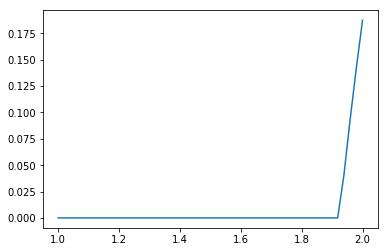

In [61]:
plt.plot(ratios,differences_from_zero_mass[0,:])
plt.show()